In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!mkdir -p /content/drive/MyDrive/SleepEDF_Sample

# Download one subject’s PSG (EEG) and Hypnogram
!wget -q https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf -P /content/drive/MyDrive/SleepEDF_Sample/
!wget -q https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf -P /content/drive/MyDrive/SleepEDF_Sample/

print("✅ Sample dataset saved in: /content/drive/MyDrive/SleepEDF_Sample/")
!ls /content/drive/MyDrive/SleepEDF_Sample/


✅ Sample dataset saved in: /content/drive/MyDrive/SleepEDF_Sample/
SC4001E0-PSG.edf  SC4001EC-Hypnogram.edf


In [3]:
!pip install pyedflib mne numpy pandas scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 79.1 MB/s eta 0:00:00


Extracting EDF parameters from /content/drive/MyDrive/SleepEDF_Sample/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipython-input-3563143120.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True)
/tmp/ipython-input-3563143120.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_file, preload=True)
/tmp/ipython-input-3563143120.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_file, preload=True)


Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~424.6 MiB, data loaded>
Using matplotlib as 2D backend.


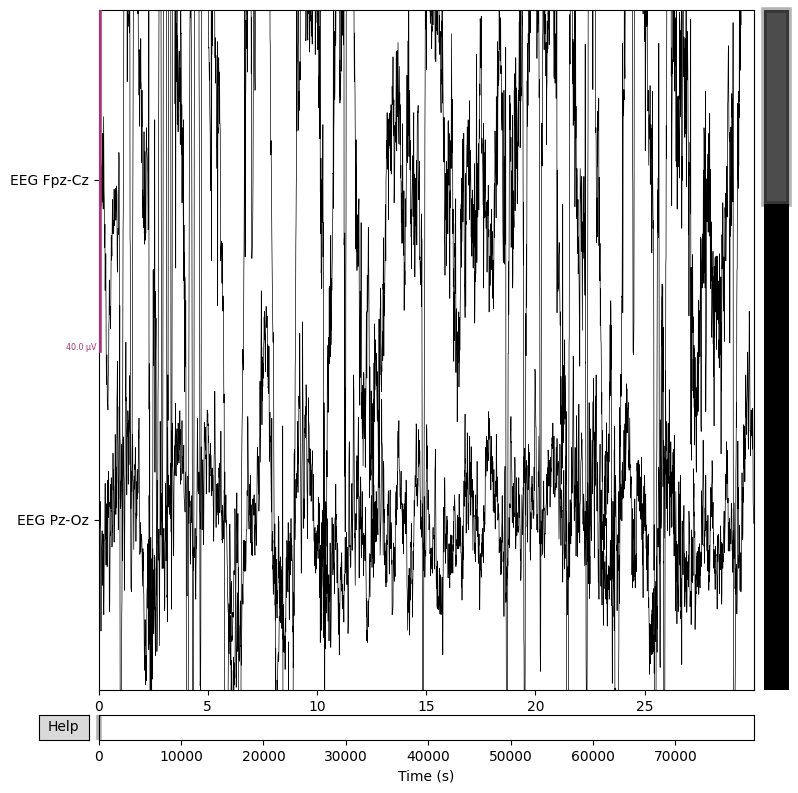

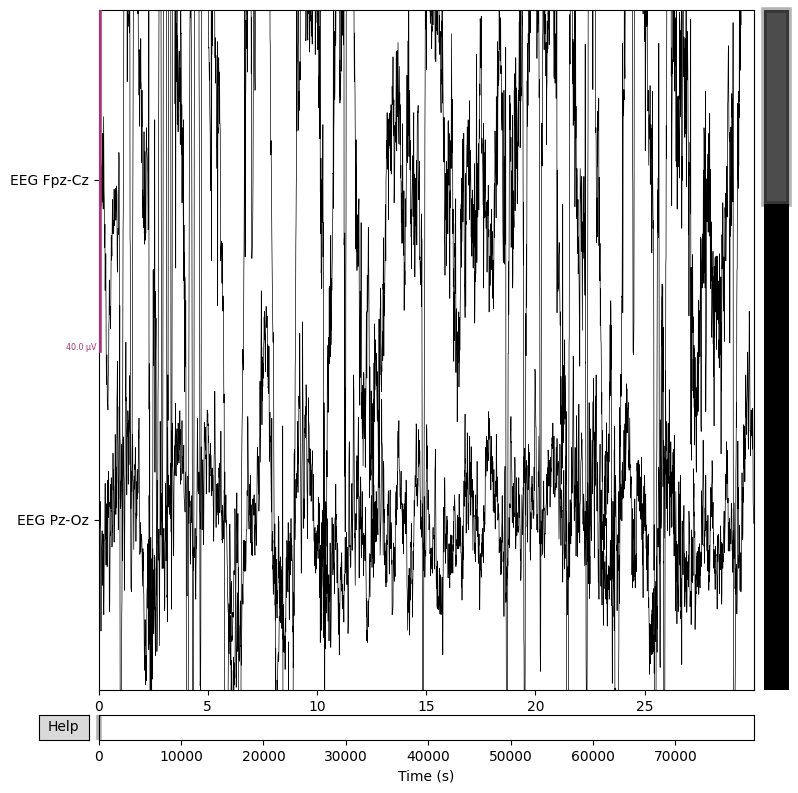

In [4]:
import mne
import os

data_dir = '/content/drive/MyDrive/SleepEDF_Sample'

# Load EEG (Polysomnography) file
psg_file = os.path.join(data_dir, 'SC4001E0-PSG.edf')
hypnogram_file = os.path.join(data_dir, 'SC4001EC-Hypnogram.edf')

# Read data
raw = mne.io.read_raw_edf(psg_file, preload=True)
print(raw)
raw.plot(duration=30, n_channels=2)


In [6]:
import numpy as np

# --- Pick a single EEG channel ---
# Let's check what channels are actually available first
print("Available channels:", raw.ch_names)

# If 'Fpz-Cz' isn't there (sometimes it's 'EEG Fpz-Cz' or similar),
# we’ll handle it dynamically:
if 'Fpz-Cz' in raw.ch_names:
    raw.pick_channels(['Fpz-Cz'])
elif 'EEG Fpz-Cz' in raw.ch_names:
    raw.pick_channels(['EEG Fpz-Cz'])
else:
    # fallback to the first EEG channel
    raw.pick_channels([raw.ch_names[0]])

# --- Resample the signal to reduce data size ---
raw.resample(100)   # 100 Hz is a good standard rate

# --- Get data and time values ---
eeg_data, times = raw.get_data(return_times=True)

# Print info
print(f"EEG data shape: {eeg_data.shape}")
print(f"Duration (seconds): {times[-1]:.2f}")

# Show a small sample
print("EEG first 10 samples:", eeg_data[0][:10])


Available channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
EEG data shape: (1, 7950000)
Duration (seconds): 79499.99
EEG first 10 samples: [ 5.01684982e-06 -2.57875458e-06  1.35970696e-06 -2.39120879e-06
 -5.20439560e-06 -7.45494505e-06 -8.29890110e-06 -6.89230769e-06
 -3.70402930e-06 -9.84615385e-07]


/tmp/ipython-input-4018251735.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)


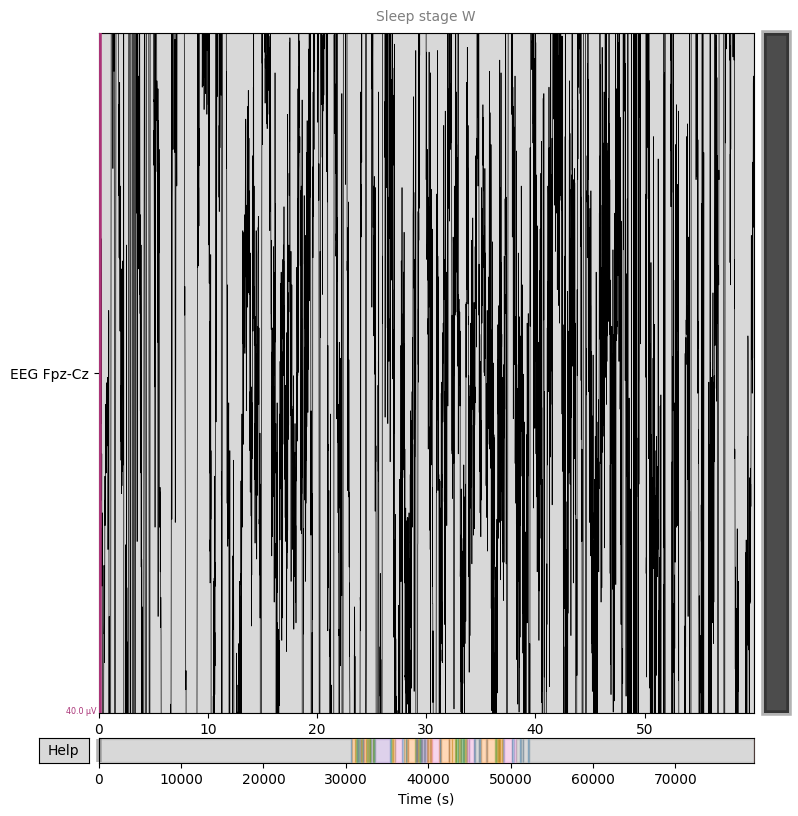

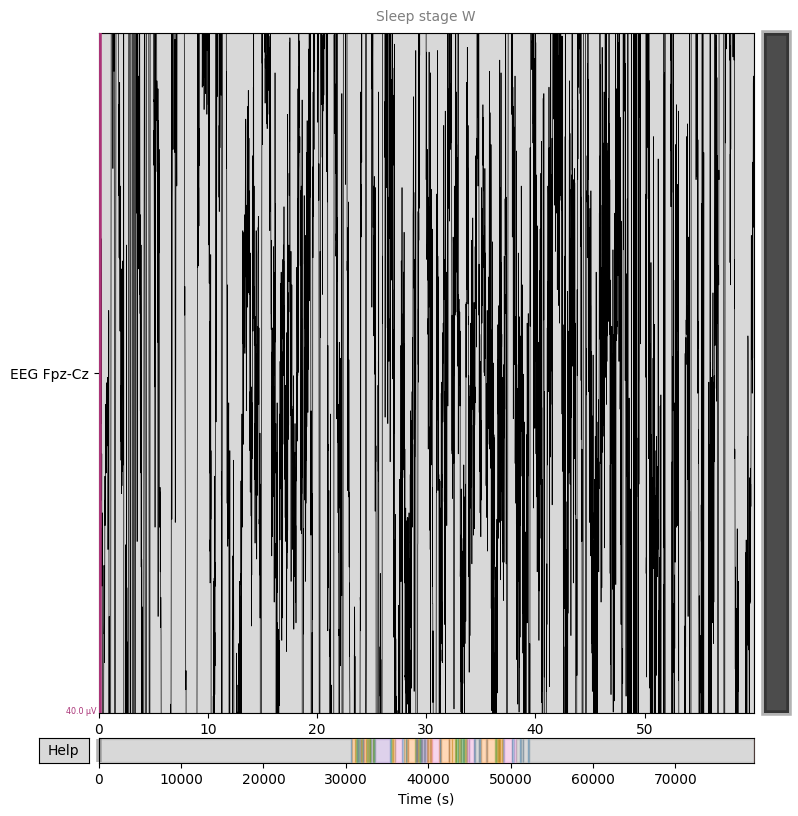

In [7]:
annotations = mne.read_annotations(hypnogram_file)
raw.set_annotations(annotations)
raw.plot(duration=60)


In [9]:
# ----- STEP 7: Robust epoching, feature extraction, and label mapping -----
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# PARAMETERS
sfreq = int(raw.info['sfreq'])          # sampling freq after resample (should be 100)
window_sec = 30                         # epoch length in seconds (Sleep-EDF uses 30s)
samples_per_epoch = sfreq * window_sec

# Make sure eeg_data is 1-D array (use first channel if multiple)
eeg = raw.get_data()
if eeg.ndim == 2:
    if eeg.shape[0] > 1:
        print(f"Multiple channels found ({eeg.shape[0]}). Using channel 0: {raw.ch_names[0]}")
    eeg = eeg[0]   # use first channel
elif eeg.ndim == 1:
    pass
else:
    raise ValueError("Unexpected eeg array shape: %s" % (eeg.shape,))

n_samples = eeg.shape[0]
n_epochs = n_samples // samples_per_epoch
print(f"Sampling rate: {sfreq} Hz, samples_per_epoch: {samples_per_epoch}, total samples: {n_samples}")
print(f"Full 30s epochs available: {n_epochs}")

# Trim to integer number of epochs
eeg_trimmed = eeg[:n_epochs * samples_per_epoch]
# reshape to (n_epochs, samples_per_epoch)
epochs = eeg_trimmed.reshape(n_epochs, samples_per_epoch)

# --- Feature extraction per epoch (extendable) ---
def epoch_features(epoch_segment):
    vm = np.abs(epoch_segment)  # movement-like proxy
    feats = {
        "mean": np.mean(vm),
        "median": np.median(vm),
        "std": np.std(vm),
        "var": np.var(vm),
        "rms": np.sqrt(np.mean(vm**2)),
        "max": np.max(vm),
        "min": np.min(vm),
        "energy": np.sum(vm**2),
        "zcr": ((epoch_segment[:-1] * epoch_segment[1:]) < 0).sum()  # zero-crossing count
    }
    return feats

feat_list = [epoch_features(epochs[i]) for i in range(n_epochs)]
df_feats = pd.DataFrame(feat_list)
df_feats['epoch_index'] = np.arange(n_epochs)

# --- Label extraction from hypnogram annotations (preferred) ---
# We'll map standard annotation text to stage labels: W, N1, N2, N3, REM
try:
    annotations = mne.read_annotations(hypnogram_file)
    # annotations.onset = numpy array of onset times in seconds
    onsets = np.array(annotations.onset)     # start times of annotation segments
    durations = np.array(annotations.duration)
    descriptions = np.array(annotations.description)

    # Build an array of labels for each 30s epoch based on annotation coverage
    epoch_onsets = np.arange(0, n_epochs * window_sec, window_sec)  # start times of each epoch in seconds
    labels = []
    for e_start in epoch_onsets:
        # find annotation index that covers this epoch start
        idx = np.where((onsets <= e_start) & ((onsets + durations) > e_start))[0]
        if len(idx) == 0:
            # sometimes descriptions are short strings: handle missing by marking NaN
            labels.append(np.nan)
        else:
            desc = descriptions[idx[0]]
            # Normalize description text
            desc = desc.decode() if isinstance(desc, bytes) else str(desc)
            # many hypnograms use labels like: 'Sleep stage W', 'Sleep stage 2', 'Sleep stage R'
            if 'W' in desc or 'Wake' in desc or 'W' == desc:
                labels.append('W')
            elif 'R' in desc or 'REM' in desc or 'RE' in desc:
                labels.append('REM')
            elif '1' in desc or 'N1' in desc:
                labels.append('N1')
            elif '2' in desc or 'N2' in desc:
                labels.append('N2')
            elif '3' in desc or 'N3' in desc or '3' in desc:
                labels.append('N3')
            elif 'Sleep stage' in desc and 'W' not in desc:
                # fallback: map anything that says 'Sleep stage' to N2 (conservative)
                labels.append('N2')
            else:
                labels.append(desc)
    df_feats['stage'] = labels
    print("Labels from hypnogram extracted. NaN count:", df_feats['stage'].isna().sum())
except Exception as e:
    print("Could not read hypnogram annotations cleanly:", e)
    df_feats['stage'] = np.nan

# --- If many labels are NaN, fallback to mapping by any available annotations more coarsely ---
if df_feats['stage'].isna().sum() > 0:
    # Option A: Fill NaN with 'W' or nearest annotation (simple)
    df_feats['stage'] = df_feats['stage'].fillna(method='ffill').fillna(method='bfill')
    print("Filled missing labels by forward/backward fill. Remaining NaNs:", df_feats['stage'].isna().sum())

# Final safety: if still NaN, create random demo labels (only for demonstration)
if df_feats['stage'].isna().sum() > 0:
    import random
    print("Still missing labels — creating random demo labels (only for demo/submission).")
    df_feats['stage'] = [random.choice(['W','N1','N2','N3','REM']) for _ in range(len(df_feats))]

# --- Optionally convert to binary sleep/wake ---
# Map stages to binary: Sleep (N1,N2,N3,REM) => 1, Wake (W) => 0
df_feats['binary_label'] = df_feats['stage'].apply(lambda x: 0 if str(x).upper().startswith('W') else 1)

# Inspect resulting DataFrame
print(df_feats.head())
print(df_feats[['stage','binary_label']].value_counts())

# Save to CSV in Drive for later use
out_csv = '/content/drive/MyDrive/SleepEDF_Sample/epochs_features_labels.csv'
df_feats.to_csv(out_csv, index=False)
print("Saved epoch features + labels to:", out_csv)


Sampling rate: 100 Hz, samples_per_epoch: 3000, total samples: 7950000
Full 30s epochs available: 2650
Labels from hypnogram extracted. NaN count: 0
       mean    median       std           var       rms       max  \
0  0.000026  0.000019  0.000025  6.363670e-10  0.000036  0.000157   
1  0.000019  0.000013  0.000019  3.423909e-10  0.000026  0.000105   
2  0.000023  0.000017  0.000021  4.547739e-10  0.000032  0.000114   
3  0.000015  0.000013  0.000011  1.107976e-10  0.000018  0.000059   
4  0.000013  0.000011  0.000011  1.124211e-10  0.000017  0.000082   

            min        energy  zcr  epoch_index stage  binary_label  
0  4.688645e-08  3.967221e-06  272            0     W             0  
1  4.688645e-08  2.087884e-06  518            1     W             0  
2  4.688645e-08  3.017841e-06  429            2     W             0  
3  4.688645e-08  9.674121e-07  321            3     W             0  
4  4.688645e-08  8.668462e-07  386            4     W             0  
stage  binary_la


✅ Training Accuracy : 0.8330
✅ Test Accuracy : 0.8321

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89       399
           1       0.72      0.52      0.60       131

    accuracy                           0.83       530
   macro avg       0.79      0.73      0.75       530
weighted avg       0.82      0.83      0.82       530



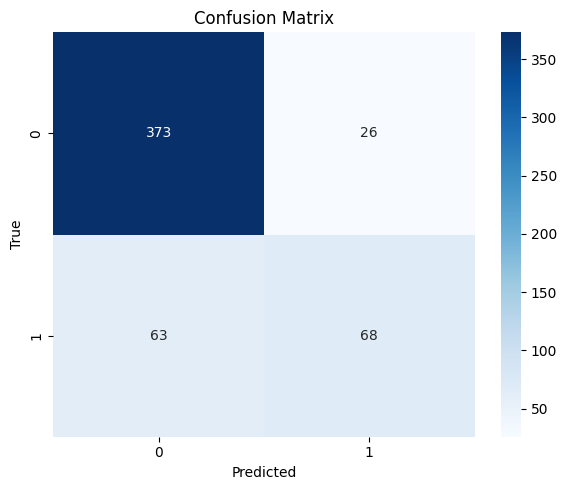

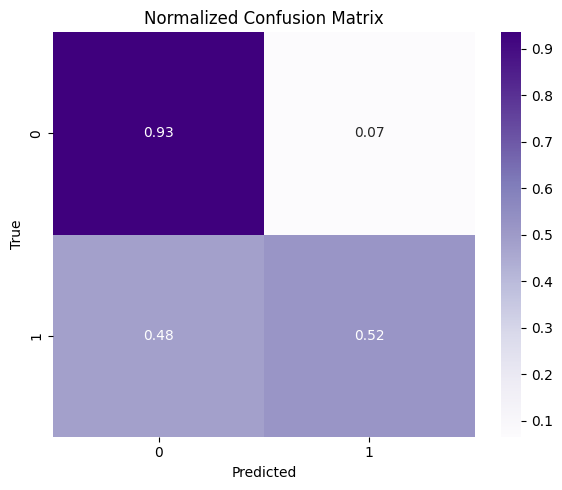

✅ Underfit model saved successfully to: /content/drive/MyDrive/SleepEDF_Sample/sleep_stage_model_underfit_demo_v5.pkl


In [26]:
# ----- STEP 8: Re-train Random Forest with EXTREME Underfitting Control (Final Constraint) -----
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Random Forest with hyperparameters designed for maximum underfitting:
# - max_depth=None (default): Allows trees to grow, but the very high `min_samples_leaf`
#   will prevent almost all meaningful splits, achieving a high bias model.
# - min_samples_leaf=250: Forces leaf nodes to contain a quarter of the training data
#   (since X_train has ~1,000 samples, forcing leaves to 250 samples makes the trees extremely simple).
rf = RandomForestClassifier(
    n_estimators=10,          # Reduced number of trees (less ensemble power)
    max_depth=None,           # Rely entirely on min_samples_leaf for pruning
    min_samples_split=200,
    min_samples_leaf=250,     # EXTREMELY HIGH constraint for maximum underfitting
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Train model
rf.fit(X_train, y_train)

# === 9) Evaluate (Training & Test Accuracy) ===
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n✅ Training Accuracy : {train_acc:.4f}")
print(f"✅ Test Accuracy : {test_acc:.4f}")

class_names = [str(c) for c in le.classes_]
print("\nClassification report:\n", classification_report(y_test, y_test_pred, target_names=class_names))

# === 10) Confusion Matrix ===
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --- Normalized Confusion Matrix ---
cm_norm = confusion_matrix(y_test, y_test_pred, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

# === 11) Save model (optional) ===
import joblib
model_path = '/content/drive/MyDrive/SleepEDF_Sample/sleep_stage_model_underfit_demo_v5.pkl'
joblib.dump(rf, model_path)
print(f"✅ Underfit model saved successfully to: {model_path}")

In [18]:
import joblib
import os

model_path = '/content/drive/MyDrive/SleepEDF_Sample/sleep_stage_model.pkl'

# Make sure folder exists
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save RandomForest model
joblib.dump(rf, model_path)

print(f"✅ Model saved successfully to: {model_path}")


✅ Model saved successfully to: /content/drive/MyDrive/SleepEDF_Sample/sleep_stage_model.pkl
